# Investments-Selected Quant Tools

## This is the notebook for the above course at 2023 spring, university of zurich, aiming to make portfolio investments using machine learning technologies.


In [1]:
# import all the library that we need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

# import classes from python files
from models import create_model
from data_processing import WindowGenerator
from data_processing import DataProcessor
from utilities import ModelPerformanceVisualizer

# import os 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
# set up the data.
df = pd.read_excel('market_data.xlsx',sheet_name='US', engine='openpyxl')
df = df.set_index(df['Date'])
df = df.drop(columns='Date')
df0 = df.copy()
cols = ['MG', 'RV', 'ED']
df = df[cols]
# denoising set-up
df_n = df + 1.0 * np.random.normal(0, 1, df.shape)
cols_n = [str(i)+'_n' for i in cols]
df_n.columns = cols_n
df = df.join(df_n)
n = len(df)
df = df.dropna()

# hold out test data
n = len(df)
df1 = df[0:int(0.8*n)]
df2 = df[int(0.8*n):]
mm_scaler = preprocessing.StandardScaler()
df1m = mm_scaler.fit_transform(df1)
df2m = mm_scaler.transform(df2)
train_df = pd.DataFrame(df1m, index=df1.index, columns=df1.columns)
test_df = pd.DataFrame(df2m, index=df2.index, columns=df2.columns)

In [3]:
lb = 30
pooling = 1
window = WindowGenerator(input_width=lb, label_width=lb, shift=0, input_columns=cols_n, label_columns=cols, all_columns=df.columns, train_df= train_df)

td = window.make_dataset(train_df, shuffle=True)
is_data = td.take(2)
os_data = td.skip(2)




In [4]:
autoencoder_units = 128
dropout_rate = 0.2
autoencoder_latent_dim = 1

autoencoder_model = create_model('autoencoder', lb = lb, num_inputs_auto = 3, num_hidden_auto = 1, kernel_size_auto = 25, pooling_auto = pooling)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=50, decay_rate=0.97, staircase=True)
autoencoder_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.SGD(learning_rate=lr_schedule), metrics=[tf.metrics.MeanSquaredError(), ])
autoencoder_model.run_eagerly = True
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')
history = autoencoder_model.fit(is_data, validation_data=os_data, epochs=500, callbacks=[early_stopping])
autoencoder_model.summary()


Epoch 1/500
2/2 [==============================] - 1s 686ms/step - loss: 1.3626 - mean_squared_error: 1.3626 - val_loss: 1.2868 - val_mean_squared_error: 1.2868
Epoch 2/500
2/2 [==============================] - 1s 457ms/step - loss: 1.3828 - mean_squared_error: 1.3828 - val_loss: 1.3499 - val_mean_squared_error: 1.3499
Epoch 3/500
2/2 [==============================] - 0s 283ms/step - loss: 1.3150 - mean_squared_error: 1.3150 - val_loss: 1.3932 - val_mean_squared_error: 1.3932
Epoch 4/500
2/2 [==============================] - 1s 379ms/step - loss: 1.3406 - mean_squared_error: 1.3406 - val_loss: 1.2049 - val_mean_squared_error: 1.2049
Epoch 5/500
2/2 [==============================] - 1s 389ms/step - loss: 1.2655 - mean_squared_error: 1.2655 - val_loss: 1.1897 - val_mean_squared_error: 1.1897
Epoch 6/500
2/2 [==============================] - 1s 402ms/step - loss: 1.2675 - mean_squared_error: 1.2675 - val_loss: 1.2409 - val_mean_squared_error: 1.2409
Epoch 7/500
2/2 [=================

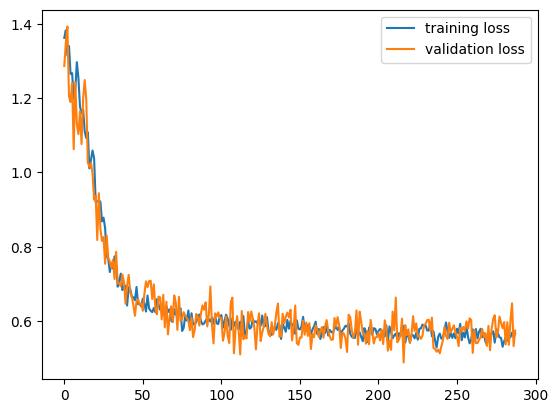

1/1 [==============================] - 0s 121ms/step


KeyError: '_MKT'

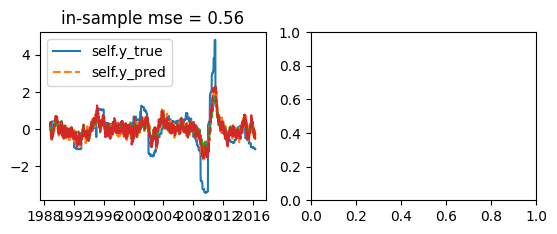

In [5]:
eval_train_autoencoder = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_autoencoder = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)
# Create an instance of the ModelPerformanceVisualizer class
visualizer = ModelPerformanceVisualizer(autoencoder_model, eval_train_autoencoder, eval_test_autoencoder, train_df, test_df, train_df, test_df, lb)

# Plot loss history
visualizer.plot_loss(history)

# Plot in-sample performance
visualizer.plot_in_sample_performance()

# Plot in-sample trading strategy
visualizer.plot_in_sample_trading_strategy()

# Plot out-of-sample performance
visualizer.plot_out_of_sample_performance()

# Plot out-of-sample trading strategy
visualizer.plot_out_of_sample_trading_strategy()

# Display all plots
visualizer.show_plots()